In [1]:
#Imports and basic setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


pd.set_option("display.max_columns", 100)
pd.set_option("display.float_format", "{:,.2f}".format)

# MEPS negative / special missing codes to treat as missing
MEPS_MISSING = {-1, -7, -8, -9, -15, 996, 997, 998, 999}

In [2]:
#load raw MEPS data (h214 = conditions, h216 = person)
path_h214 = "h214.csv"
path_h216 = "h216.csv"

h214 = pd.read_csv(path_h214)
h216 = pd.read_csv(path_h216)

print(h214.shape, h216.shape)

(87561, 28) (28512, 1447)


In [3]:
#Restrict to Type 2 Diabetes (ICD10CDX starts with E11)

#Keep only rows with T2D diagnosis in condition file
cond_t2d = h214[h214["ICD10CDX"].astype(str).str.startswith("E11", na=False)]
t2d_ids = cond_t2d["DUPERSID"].unique()
print("Unique T2D patients:", len(t2d_ids))

df = h216[h216["DUPERSID"].isin(t2d_ids)].copy()
print("Matched T2D rows in person file:", df.shape)

Unique T2D patients: 2508
Matched T2D rows in person file: (2508, 1447)


In [4]:
#Select variables (OBDEXP19 is the outcome)

cols_keep = [
    "DUPERSID",
    "AGE53X",
    "SEX",
    "RACETHX",
    "HISPANX",
    "EDUCYR",
    "ADGENH42",
    "ADSMOK42",
    "HIBPDX",
    "CHOLDX",
    "LFTDIF31",
    "OBDEXP19"
]

df = df[cols_keep].copy()

print("\nInitial columns:")
print(df.head())

# ------------------------------------------------------------
# 4. Replace MEPS special codes with NaN
# ------------------------------------------------------------
print("\nMEPS missing codes BEFORE cleaning:")
print(df.isin(MEPS_MISSING).sum())

df = df.replace({v: np.nan for v in MEPS_MISSING})

print("\nMissing values AFTER replacing MEPS codes with NaN:")
print(df.isna().sum())


Initial columns:
      DUPERSID  AGE53X  SEX  RACETHX  HISPANX  EDUCYR  ADGENH42  ADSMOK42  \
9   2320012102      79    2        2        2      12         2         2   
17  2320019104      46    1        1        1      12         2         2   
19  2320022102      52    2        2        2      12         3         1   
44  2320034101      54    2        1        1      12        -1        -1   
63  2320040101      61    1        2        2      12         3         2   

    HIBPDX  CHOLDX  LFTDIF31  OBDEXP19  
9        1       1        -1       562  
17       1       2         1      9034  
19       1       1         1         0  
44       2       2        -1         0  
63       1       2        -1      2245  

MEPS missing codes BEFORE cleaning:
DUPERSID       0
AGE53X        49
SEX            0
RACETHX        0
HISPANX        0
EDUCYR        24
ADGENH42     482
ADSMOK42     387
HIBPDX        28
CHOLDX        31
LFTDIF31    1594
OBDEXP19       4
dtype: int64

Missing values AFT

In [5]:
#Label categorical variables (fix numeric labels)
sex_map   = {1: "Male", 2: "Female"}
race_map  = {1: "Hispanic", 2: "White", 3: "Black", 4: "Asian", 5: "Other"}
smoke_map = {1: "Current smoker", 2: "Non-smoker"}
genh_map  = {1: "Excellent", 2: "Very good", 3: "Good", 4: "Fair", 5: "Poor"}
hibp_map  = {1: "Has hypertension", 2: "No hypertension"}
chol_map  = {1: "Has high cholesterol", 2: "No high cholesterol"}
pa_map  = {1: "Limited", 2: "Not limited"}


df["SEX_LABEL"] = df["SEX"].map(sex_map)
df["RACE_LABEL"] = df["RACETHX"].map(race_map)
df["SMOKE_LABEL"] = df["ADSMOK42"].map(smoke_map)
df["GENHLTH_LABEL"] = df["ADGENH42"].map(genh_map)
df["HIBP_LABEL"] = df["HIBPDX"].map(hibp_map)
df["CHOL_LABEL"] = df["CHOLDX"].map(chol_map)
df["PA_LEVEL"] = df["LFTDIF31"].map(pa_map)


print("\nCheck recoded labels (SEX & RACE):")
display(df[["SEX", "SEX_LABEL", "RACETHX", "RACE_LABEL"]].head())

#GENHLTH_LABEL is ADGENH42 renamed to have a better understanding showing the general health of the patient


Check recoded labels (SEX & RACE):


,SEX,SEX_LABEL,RACETHX,RACE_LABEL
9,2,Female,2,White
17,1,Male,1,Hispanic
19,2,Female,2,White
44,2,Female,1,Hispanic
63,1,Male,2,White


In [6]:
#Create age groups
def make_age_group(age):
    if pd.isna(age):
        return np.nan
    age = int(age)
    if age < 45:
        return "30–44"
    elif age < 65:
        return "45–64"
    else:
        return "65+"

df["AGEGRP"] = df["AGE53X"].apply(make_age_group)

print("\nAge group counts:")
print(df["AGEGRP"].value_counts(dropna=False))


Age group counts:
65+      1237
45–64     962
30–44     260
NaN        49
Name: AGEGRP, dtype: int64


In [7]:
#Impute missing values
#    - Categorical: mode
#    - Numeric: median
# ------------------------------------------------------------

# Categorical columns in the exported file
categorical_cols = [
    "SEX_LABEL",
    "RACE_LABEL",
    "GENHLTH_LABEL",
    "SMOKE_LABEL",
    "HIBP_LABEL",
    "CHOL_LABEL",
    "AGEGRP",
    "PA_LEVEL"
]

# Numeric columns in the exported file
numeric_cols = [
    "AGE53X",
    "EDUCYR",
    "OBDEXP19"
]

# Mode imputation for categorical variables
for col in categorical_cols:
    if col in df.columns:
        mode_val = df[col].mode(dropna=True)[0]
        df[col] = df[col].fillna(mode_val)
        print(f"{col}: filled missing with MODE → {mode_val}")

# Median imputation for numeric variables
for col in numeric_cols:
    if col in df.columns:
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)
        print(f"{col}: filled missing with MEDIAN → {median_val}")

print("\nMissing values AFTER mode/median imputation:")
print(df.isna().sum())

SEX_LABEL: filled missing with MODE → Female
RACE_LABEL: filled missing with MODE → White
GENHLTH_LABEL: filled missing with MODE → Good
SMOKE_LABEL: filled missing with MODE → Non-smoker
HIBP_LABEL: filled missing with MODE → Has hypertension
CHOL_LABEL: filled missing with MODE → Has high cholesterol
AGEGRP: filled missing with MODE → 65+
PA_LEVEL: filled missing with MODE → Not limited
AGE53X: filled missing with MEDIAN → 65.0
EDUCYR: filled missing with MEDIAN → 12.0
OBDEXP19: filled missing with MEDIAN → 725.5

Missing values AFTER mode/median imputation:
DUPERSID            0
AGE53X              0
SEX                 0
RACETHX             0
HISPANX             0
EDUCYR              0
ADGENH42          482
ADSMOK42          387
HIBPDX             28
CHOLDX             31
LFTDIF31         1594
OBDEXP19            0
SEX_LABEL           0
RACE_LABEL          0
SMOKE_LABEL         0
GENHLTH_LABEL       0
HIBP_LABEL          0
CHOL_LABEL          0
PA_LEVEL            0
AGEGRP         


=== Distribution of OBDEXP19 ===
N: 2508
Mean: 1818.6259968102074
Median: 725.5
Std: 4342.222884612318
Skewness: 8.225861994945463
Kurtosis: 91.56379167032705


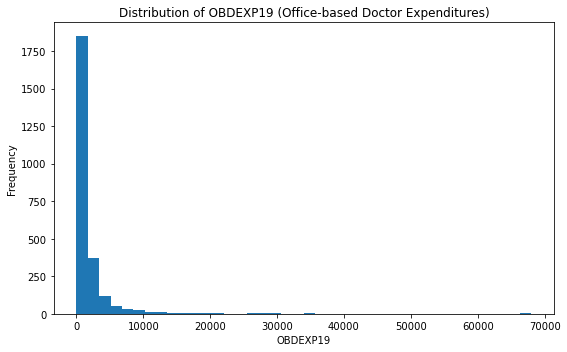

In [8]:
 #Distribution of OBDEXP19
# ============================================================
obd = df["OBDEXP19"].dropna()
print("\n=== Distribution of OBDEXP19 ===")
print("N:", len(obd))
print("Mean:", obd.mean())
print("Median:", obd.median())
print("Std:", obd.std())
print("Skewness:", obd.skew())
print("Kurtosis:", obd.kurtosis())
plt.figure(figsize=(8,5))
plt.hist(obd, bins=40)
plt.title("Distribution of OBDEXP19 (Office-based Doctor Expenditures)")
plt.xlabel("OBDEXP19")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [9]:
#Remove outliers from OBDEXP19 using 1.5 × IQR (on imputed values)
# ------------------------------------------------------------
obd = df["OBDEXP19"]

Q1 = obd.quantile(0.25)
Q3 = obd.quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

print("\nOutlier bounds for OBDEXP19 (raw after imputation):")
print("Q1:", Q1, " Q3:", Q3, " IQR:", IQR)
print("Lower bound:", lower, " Upper bound:", upper)

outlier_mask = (df["OBDEXP19"] < lower) | (df["OBDEXP19"] > upper)
num_outliers = outlier_mask.sum()

df_clean = df[~outlier_mask].copy()

print("\nNumber of outliers removed (OBDEXP19):", num_outliers)
print("Final cleaned dataset shape:", df_clean.shape)


Outlier bounds for OBDEXP19 (raw after imputation):
Q1: 250.0  Q3: 1787.75  IQR: 1537.75
Lower bound: -2056.625  Upper bound: 4094.375

Number of outliers removed (OBDEXP19): 219
Final cleaned dataset shape: (2289, 20)



=== Distribution of OBDEXP19 AFTER outlier removal ===
N: 2289
Mean: 944.2114460463084
Median: 612.0
Std: 964.4002821104252
Skewness: 1.2856865267031836
Kurtosis: 0.9192049545277392


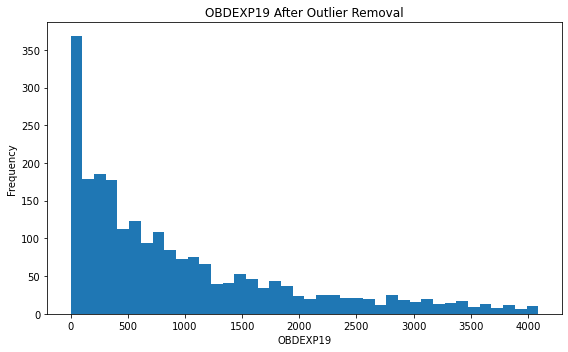

266

In [10]:
 #Distribution of OBDEXP19 AFTER outlier removal (optional)
# ============================================================
obd_clean = df_clean["OBDEXP19"].dropna()
print("\n=== Distribution of OBDEXP19 AFTER outlier removal ===")
print("N:", len(obd_clean))
print("Mean:", obd_clean.mean())
print("Median:", obd_clean.median())
print("Std:", obd_clean.std())
print("Skewness:", obd_clean.skew())
print("Kurtosis:", obd_clean.kurtosis())
plt.figure(figsize=(8,5))
plt.hist(obd_clean, bins=40)
plt.title("OBDEXP19 After Outlier Removal")
plt.xlabel("OBDEXP19")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()
df_clean[df_clean["OBDEXP19"] == 0].shape[0]

In [11]:
#Select columns to export for Phase 3 descriptive analysis
# ------------------------------------------------------------
cols_export = [
    "DUPERSID",
    "AGE53X",
    "AGEGRP",
    "EDUCYR",
    "SEX_LABEL",
    "RACE_LABEL",
    "GENHLTH_LABEL",
    "SMOKE_LABEL",
    "HIBP_LABEL",
    "CHOL_LABEL",
    "PA_LEVEL",
    "OBDEXP19"
]

export_df = df_clean[cols_export].copy()

print("\nPreview of data to export:")
print(export_df.head())


Preview of data to export:
      DUPERSID  AGE53X AGEGRP  EDUCYR SEX_LABEL RACE_LABEL GENHLTH_LABEL  \
9   2320012102   79.00    65+   12.00    Female      White     Very good   
19  2320022102   52.00  45–64   12.00    Female      White          Good   
44  2320034101   54.00  45–64   12.00    Female   Hispanic          Good   
63  2320040101   61.00  45–64   12.00      Male      White          Good   
75  2320050101   38.00  30–44   14.00    Female      White          Fair   

       SMOKE_LABEL        HIBP_LABEL            CHOL_LABEL     PA_LEVEL  \
9       Non-smoker  Has hypertension  Has high cholesterol  Not limited   
19  Current smoker  Has hypertension  Has high cholesterol      Limited   
44      Non-smoker   No hypertension   No high cholesterol  Not limited   
63      Non-smoker  Has hypertension   No high cholesterol  Not limited   
75  Current smoker  Has hypertension   No high cholesterol  Not limited   

    OBDEXP19  
9     562.00  
19      0.00  
44      0.00  
63  

In [12]:
#Export to Excel for Phase 3 analysis
# ------------------------------------------------------------
output_path = "t2d_OBDEXP19_final_imputed.xlsx"
export_df.to_excel(output_path, index=False)

print(f"\nCleaned, imputed dataset exported to: {output_path}")


Cleaned, imputed dataset exported to: t2d_OBDEXP19_final_imputed.xlsx
